## 1- Introduction

## 2- Install pip and libraries

In [ ]:
!pip install transformers torch farasapy pyarabic































   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 9.5 MB/s eta 0:00:00




In [ ]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt




## 3- Load and Explore Data
The Dataset is from Kalimat dataset (https://sourceforge.net/projects/kalimat/)
The code loads a dataset from a CSV file and previews the first few rows. It also examines the distribution of labels to understand the balance of different classes in the dataset.


In [ ]:

# Load the KALIMAT dataset from a CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output.csv')

# Inspect the dataset
print("Dataset preview:")
df.head()

Dataset preview:


,text,label
0,كتب سالم الرحبي : تنطلق اليوم الدورة البرامجية...,culture
1,كتب - فيصل العلوي : شاركت السلطنة صباح امس دول...,culture
2,اربعة عروض على مسرح الشباب وعرض في الرستاق ثم ...,culture
3,حاوره خالد عبداللطيف : حين يناقش الموضوع الثقا...,culture
4,افتتح صباح أمس بقاعة الموسيقي في جامعة السلطان...,culture


In [ ]:
# Check the distribution of the labels
print("Label distribution:")
print(df['label'].value_counts())

Label distribution:

label

sports           4079

religion         3463

economy          3256

local            3229

culture          2495

international    1682

Name: count, dtype: int64



## 4- Preprocess and prepare data for AraBERT

proper tokenization and preparation for BERT compatibility by taking the following steps:

* Splits the dataset into training (80%) and testing (20%) sets



In [ ]:

# Split the data into training (80%) and testing (20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


* Create label mappings and converting the labels from string format to integer format using a mapping dictionary.



In [ ]:
# Create label mappings (e.g., "culture" -> 0, "economy" -> 1, etc.)
label_list = df['label'].unique().tolist()
label_map = {label: idx for idx, label in enumerate(label_list)}

# Convert labels to integers
train_labels = train_df['label'].apply(lambda x: label_map[x]).tolist()
test_labels = test_df['label'].apply(lambda x: label_map[x]).tolist()


In [ ]:
label_map

{'culture': 0,
 'economy': 1,
 'international': 2,
 'local': 3,
 'religion': 4,
 'sports': 5}

* Load a pre-trained Arabic BERT tokenizer and tokenize your training and testing datasets.



In [ ]:

# Load the pre-trained tokenizer for Arabic BERT
model_name = 'aubmindlab/bert-base-arabertv02'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define a maximum sequence length for tokenization
max_len = 512

# Function to tokenize the dataset
def tokenize_text(texts, max_len):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')

# Tokenize the training and testing data
train_encodings = tokenize_text(train_df['text'].tolist(), max_len)
test_encodings = tokenize_text(test_df['text'].tolist(), max_len)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 

The secret `HF_TOKEN` does not exist in your Colab secrets.

To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.

You will be able to reuse this secret in all of your notebooks.

Please note that authentication is recommended but still optional to access public models or datasets.

  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884

  warnings.warn(


* Specify a custom dataset class to handle BERT inputs.



In [ ]:
# Create a custom Dataset class for handling BERT input
class ArticleDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

* Create dataset objects for training and testing using the ArticleDataset class.

In [ ]:
# Create dataset objects for training and testing
train_dataset = ArticleDataset(train_encodings, train_labels)
test_dataset = ArticleDataset(test_encodings, test_labels)



## 5-Text Classification using BERT¶

fine-tuning a BERT model using the transformers library's Trainer API by taking the following steps:

* Disable Weights & Biases: This disables automatic logging to Weights & Biases (W&B), which is often used for experiment tracking.



In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

* Load Pre-trained BERT for Sequence Classification:
    The AutoModelForSequenceClassification class loads a pre-trained BERT model specifically for text classification tasks. The num_labels argument is set to the number of unique labels in your dataset (label_list).



In [ ]:
# Fine-tune BERT Model for Text Classification

# Load the pre-trained BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list))


* Define Training Arguments and Initialize the Trainer:

In [ ]:

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',              # Output directory
    num_train_epochs=3,                  # Number of training epochs
    per_device_train_batch_size=16,      # Batch size for training
    per_device_eval_batch_size=32,       # Batch size for evaluation
    evaluation_strategy="epoch",         # Evaluate every epoch
    save_strategy="epoch",               # Save model at the end of each epoch
    logging_dir='./logs',                # Directory for storing logs
    learning_rate=2e-5,                  # Learning rate
    load_best_model_at_end=True          # Load the best model at the end of training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The BERT model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=test_dataset            # Evaluation dataset
)

* Train the Model: This starts the training process. The model will be fine-tuned on the train_dataset and evaluated on the test_dataset after each epoch

In [ ]:
# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

  warnings.warn(

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).

<ipython-input-14-6c8523a3ad37>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  item = {key: torch.tensor(va

Epoch,Training Loss,Validation Loss
1,0.350700,0.191257
2,0.118100,0.170234
3,0.064900,0.175363


<ipython-input-14-6c8523a3ad37>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

<ipython-input-14-6c8523a3ad37>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

<ipython-input-14-6c8523a3ad37>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=2733, training_loss=0.15030334478239415, metrics={'train_runtime': 4467.9091, 'train_samples_per_second': 9.778, 'train_steps_per_second': 0.612, 'total_flos': 1.1495471735605248e+16, 'train_loss': 0.15030334478239415, 'epoch': 3.0})

In [ ]:
# Evaluate the model on the test set
results = trainer.evaluate()
print(f"Evaluation Results: {results}")

<ipython-input-14-6c8523a3ad37>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation Results: {'eval_loss': 0.17023445665836334, 'eval_runtime': 106.1539, 'eval_samples_per_second': 34.299, 'eval_steps_per_second': 1.074, 'epoch': 3.0}


## 6- Evaluate Text Classification¶
* Print the classification report

In [ ]:
# Predict labels on the test set
predictions = trainer.predict(test_dataset).predictions
pred_labels = predictions.argmax(axis=1)

# Print the classification report with precision, recall, F1-score, and accuracy
print(classification_report(test_labels, pred_labels, target_names=label_list))

<ipython-input-14-6c8523a3ad37>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


               precision    recall  f1-score   support



      culture       0.96      0.93      0.95       482

      economy       0.89      0.93      0.91       661

international       0.96      0.96      0.96       330

        local       0.92      0.88      0.90       662

     religion       1.00      1.00      1.00       713

       sports       0.99      1.00      0.99       793



     accuracy                           0.95      3641

    macro avg       0.95      0.95      0.95      3641

 weighted avg       0.95      0.95      0.95      3641




* Calculate the accuracy

In [ ]:

# Calculate accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy}")



Accuracy: 0.9533095303488053


* Show the confusion matrix

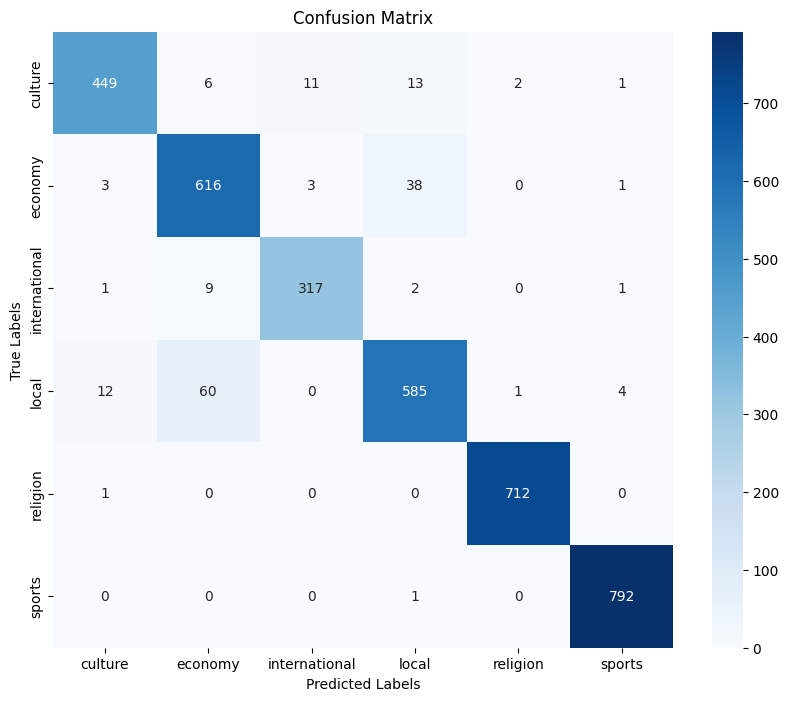

In [ ]:
# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_labels, pred_labels)
# Visualizing the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 7- Predict new Text

In [ ]:
# Classify new text
def classify_new_text(text, model, tokenizer, max_len=512):
    # Tokenize the input text
    encodings = tokenizer(text, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')

    # Move inputs to device (GPU or CPU)
    input_ids = encodings['input_ids'].to(torch.device('cpu'))
    attention_mask = encodings['attention_mask'].to(torch.device('cpu'))

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get the predicted label
    logits = outputs.logits
    pred_label = logits.argmax(axis=1).item()

    # Convert the label back to its original name
    label_name = label_list[pred_label]
    return label_name

# Example of classifying new text
new_text = "مباراة كرة القدم بين الهلال والنصر"
model = AutoModelForSequenceClassification.from_pretrained('/content/results/checkpoint-2733')  # Load the saved model
predicted_label = classify_new_text(new_text, model, tokenizer)
print(f"Predicted label for new text: {predicted_label}")

Predicted label for new text: sports
